Задание 1. Нужно сгенерировать синтетический датасет для задачи классификации, построить модели с использованием различных алгоритмов, провести поиск наилучших гиперпараметров и оценить качество моделей с использованием коэффициента Джини.

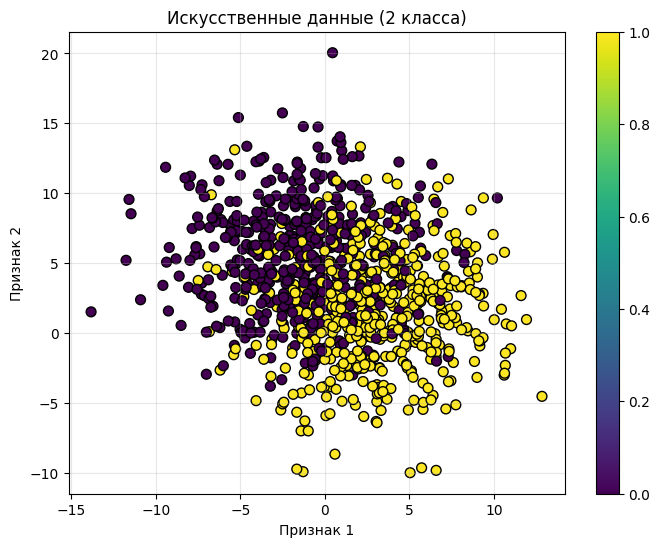


Модель: Логистическая регрессия
Лучшие параметры: {'C': 0.1}
AUC-ROC: 0.8928
Коэффициент Джини: 0.7857

Модель: SVM
Лучшие параметры: {'C': 0.1, 'gamma': 0.01}
AUC-ROC: 0.8916
Коэффициент Джини: 0.7833

Модель: Дерево решений
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10}
AUC-ROC: 0.8596
Коэффициент Джини: 0.7192

Модель: Случайный лес
Лучшие параметры: {'max_depth': 5, 'n_estimators': 10}
AUC-ROC: 0.8772
Коэффициент Джини: 0.7543

ИТОГИ: сравнение моделей
--------------------------------------------------
Логистическая регрессия:
  AUC-ROC   = 0.8928
  Джини     = 0.7857
  Параметры = {'C': 0.1}
SVM:
  AUC-ROC   = 0.8916
  Джини     = 0.7833
  Параметры = {'C': 0.1, 'gamma': 0.01}
Дерево решений:
  AUC-ROC   = 0.8596
  Джини     = 0.7192
  Параметры = {'max_depth': 5, 'min_samples_split': 10}
Случайный лес:
  AUC-ROC   = 0.8772
  Джини     = 0.7543
  Параметры = {'max_depth': 5, 'n_estimators': 10}


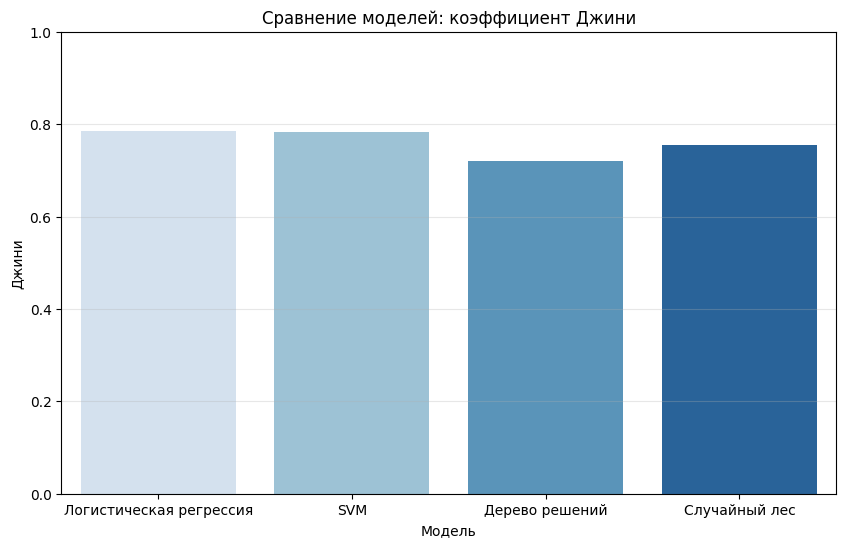

In [29]:
# Импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1. Создаём искусственные данные (2 класса, 2 признака)
X, y = make_blobs(
    n_samples=1000,        # всего 1000 точек
    n_features=2,         # 2 признака (координаты)
    centers=2,          # 2 класса
    cluster_std=3.8,   # разброс точек внутри класса
    center_box=(-6.0, 6.0),  # где расположены центры
    random_state=42     # чтобы результат повторялся
)

# 2. Рисуем данные
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title('Искусственные данные (2 класса)')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.colorbar()  # легенда цветов
plt.grid(True, alpha=0.3)
plt.show()

# 3. Делим данные: 70% — обучение, 30% — тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Нормализуем признаки (делаем их «в одном масштабе»)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # обучаем на тренировочных данных
X_test_scaled = scaler.transform(X_test)      # применяем к тестовым


# 5. Готовим модели и диапазоны параметров для подбора
models = {
    'Логистическая регрессия': {
        'model': LogisticRegression(random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
    },
    'Дерево решений': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Случайный лес': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_depth': [5, 10, 20]
        }
    }
}

# 6. Обучаем модели и ищем лучшие параметры
results = {}  # сюда будем сохранять результаты


for name, config in models.items():
    print(f"\n{'='*40}")
    print(f"Модель: {name}")

    # Настройка поиска лучших параметров (GridSearch)
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,                   # 5 частей для кросс‑валидации
        scoring='roc_auc',     # метрика качества
        n_jobs=-1              # использовать все ядра процессора
    )

    # Обучаем модель с поиском лучших параметров
    grid.fit(X_train_scaled, y_train)


    # Выводим лучшие параметры
    best_params = grid.best_params_
    print(f"Лучшие параметры: {best_params}")


    # Предсказываем вероятности для класса «1» на тестовых данных
    y_pred_proba = grid.predict_proba(X_test_scaled)[:, 1]


    # Считаем AUC-ROC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC: {auc:.4f}")


    # Считаем коэффициент Джини: Gini = 2 * AUC - 1
    gini = 2 * auc - 1
    print(f"Коэффициент Джини: {gini:.4f}")

    # Сохраняем результаты
    results[name] = {'auc': auc, 'gini': gini, 'params': best_params}

# 7. Выводим итоговые результаты
print(f"\n{'='*50}")
print("ИТОГИ: сравнение моделей")
print('-' * 50)

for name, res in results.items():
    print(f"{name}:")
    print(f"  AUC-ROC   = {res['auc']:.4f}")
    print(f"  Джини     = {res['gini']:.4f}")
    print(f"  Параметры = {res['params']}")

# 8. Рисуем график сравнения моделей по Джини
plt.figure(figsize=(10, 6))
names = list(results.keys())
gini_values = [res['gini'] for res in results.values()]

sns.barplot(x=names, y=gini_values, palette='Blues')
plt.title('Сравнение моделей: коэффициент Джини')
plt.ylabel('Джини')
plt.xlabel('Модель')
plt.ylim(0, 1)  # Джини от 0 до 1
plt.grid(axis='y', alpha=0.3)
plt.show()


Задание 2. Нужно сгенерировать синтетический датасет для задачи регрессии, построить модель с использованием бэггинга, провести анализ результатов и оценить качество модели.

1. Создаём искусственные данные для регрессии

Первые 5 строк данных:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5   
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137  \
1  -0.463418  -0.465730   0.241962  -1.913280  -1.724918  -0.562288   
2   1.465649  -0.225776   0.067528  -1.424748  -0.544383   0.110923   
3  -0.601707   1.852278  -0.013497  -1.057711   0.822545  -1.220844   
4   0.738467   0.171368  -0.115648  -0.301104  -1.478522  -0.719844   

   feature_6  feature_7  feature_8  feature_9    target  
0   1.579213   0.767435  -0.469474   0.542560  2.131320  
1  -1.012831   0.314247  -0.908024  -1.412304 -2.324914  
2  -1.150994   0.375698  -0.600639  -0.291694 -4.351437  
3   0.208864  -1.959670  -1.328186   0.196861  4.221572  
4  -0.460639   1.057122   0.343618  -1.763040 -3.931411  

Всего строк: 1000, столбцов: 11

2. Делим данные на обучение и тест (80% / 20%)

Обучение: 800 строк
Тест: 200 строк

3. Обучаем модель бэггинга с линейно

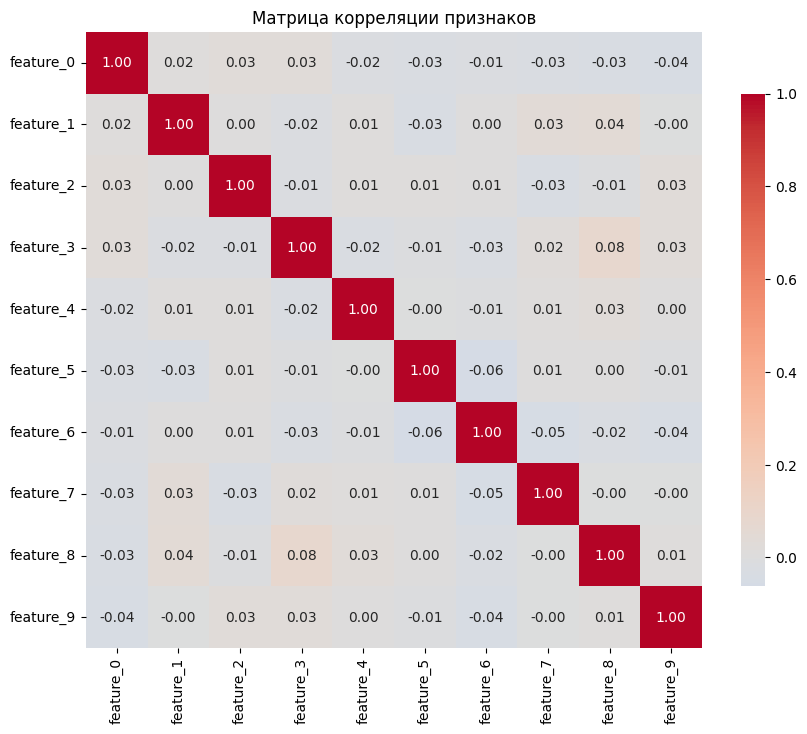

Коэффициент инфляции дисперсии (VIF) для каждого признака:
     feature       VIF
0  feature_0  1.006393
1  feature_1  1.005123
2  feature_2  1.003296
3  feature_3  1.010836
4  feature_4  1.002321
5  feature_5  1.006081
6  feature_6  1.009424
7  feature_7  1.005740
8  feature_8  1.011893
9  feature_9  1.004816

Признаки с VIF > 5 могут быть сильно связаны друг с другом:
Empty DataFrame
Columns: [feature, VIF]
Index: []

6. Анализируем остатки модели



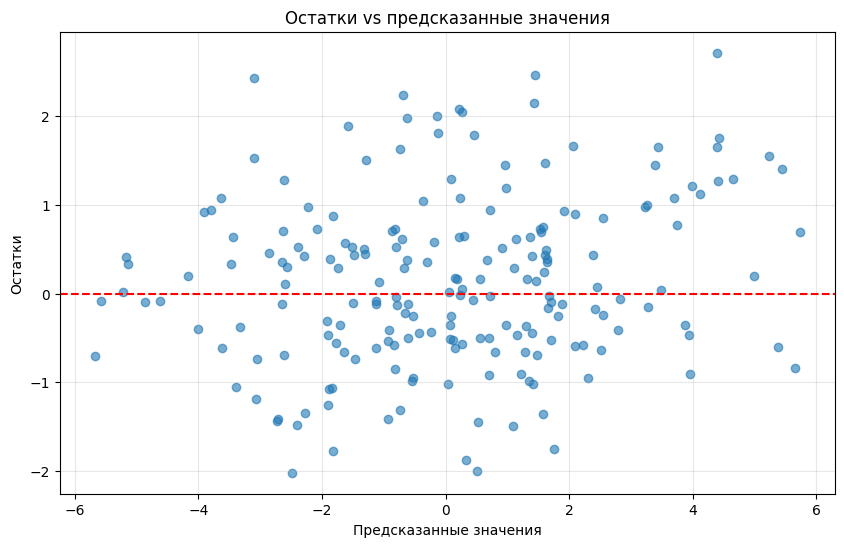

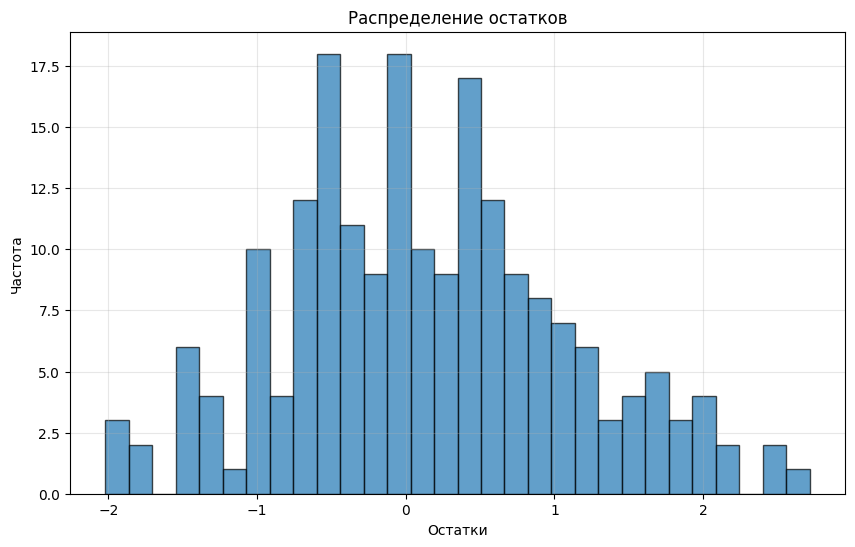

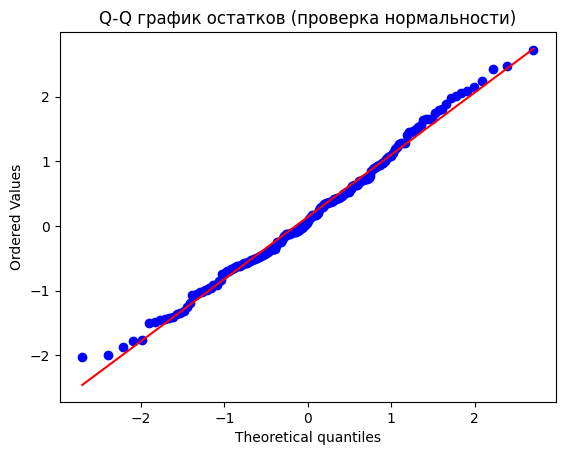


7. Смотрим, какие признаки важнее для модели

Важность признаков (по абсолютным значениям коэффициентов):
     feature  mean_coefficient  abs_coefficient
4  feature_4          1.173340         1.173340
6  feature_6          0.972371         0.972371
8  feature_8         -0.854679         0.854679
9  feature_9          0.774959         0.774959
5  feature_5         -0.769336         0.769336
7  feature_7         -0.727823         0.727823
0  feature_0         -0.706275         0.706275
2  feature_2         -0.568873         0.568873
1  feature_1         -0.307176         0.307176
3  feature_3          0.169780         0.169780


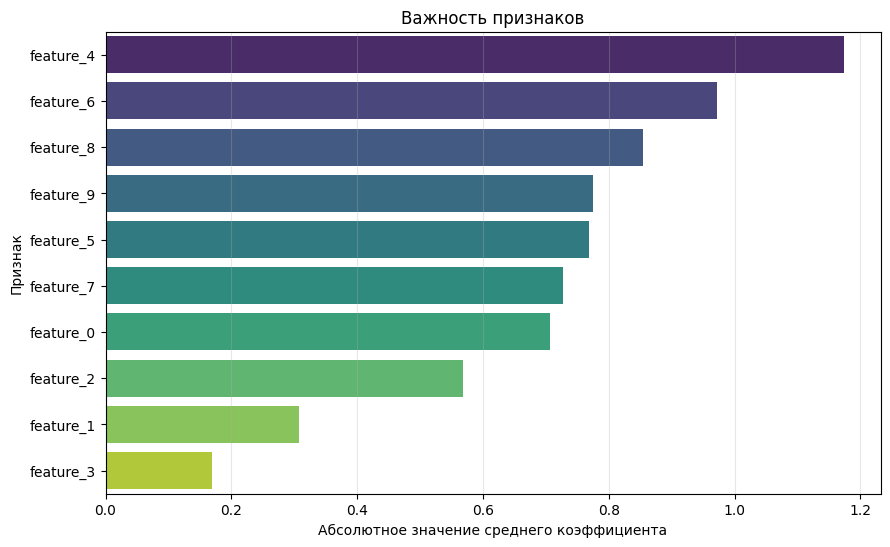


=== ИТОГИ ===

Модель: Bagging с LinearRegression (50 базовых моделей)
MSE = 0.9305  (чем меньше, тем лучше)
R² = 0.8761    (чем ближе к 1, тем лучше)

Выводы:
- Мультиколлинеарность: если VIF > 5, признаки сильно связаны — это может мешать модели.
- Остатки: распределены примерно нормально, нет явных паттернов — это хорошо.
- Важность признаков: чем больше абсолютное значение коэффициента, тем сильнее признак влияет на предсказание.


In [30]:
# Импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Убираем предупреждения (чтобы не мешали в выводе)
import warnings
warnings.filterwarnings('ignore')

print("1. Создаём искусственные данные для регрессии\n")

# Фиксируем случайность, чтобы результаты повторялись
np.random.seed(42)

# Параметры данных
n_samples = 1000  # 1000 строк
n_features = 10     # 10 признаков

# Создаём случайные признаки (X)
X = np.random.randn(n_samples, n_features)

# Коэффициенты для расчёта целевой переменной
coefficients = np.random.randn(n_features)

# Шум (случайные отклонения)
noise = np.random.normal(0, 1, n_samples)

# Целевая переменная: линейная комбинация признаков + шум
y = X @ coefficients + noise

# Делаем DataFrame (таблицу) для удобства
feature_names = [f'feature_{i}' for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y


print("Первые 5 строк данных:")
print(df.head())
print(f"\nВсего строк: {df.shape[0]}, столбцов: {df.shape[1]}")

print("\n2. Делим данные на обучение и тест (80% / 20%)\n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Обучение: {X_train.shape[0]} строк")
print(f"Тест: {X_test.shape[0]} строк")


print("\n3. Обучаем модель бэггинга с линейной регрессией\n")

# Базовая модель — линейная регрессия
base_model = LinearRegression()

# Модель бэггинга: 50 базовых моделей, работаем параллельно
bagging_model = BaggingRegressor(
    base_estimator=base_model,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

# Обучаем модель на обучающих данных
bagging_model.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
y_pred = bagging_model.predict(X_test)


print("Модель обучена!")

print("\n4. Оцениваем качество модели\n")

# Считаем ошибки
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Средняя квадратичная ошибка (MSE): {mse:.4f}")
print(f"Коэффициент детерминации (R²): {r2:.4f}")

print("(R² показывает, насколько хорошо модель объясняет данные: чем ближе к 1, тем лучше)")


print("\n5. Проверяем мультиколлинеарность (связь между признаками)\n")

# Матрица корреляции: показывает связь между признаками
corr_matrix = df[feature_names].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции признаков')
plt.show()


# VIF — число, показывающее мультиколлинеарность
def calculate_vif(data, feature_names):
    vif_data = pd.DataFrame()
    vif_data["feature"] = feature_names
    vif_data["VIF"] = [
        variance_inflation_factor(data.values, i) for i in range(data.shape[1])
    ]
    return vif_data

vif_df = calculate_vif(df[feature_names], feature_names)

print("Коэффициент инфляции дисперсии (VIF) для каждого признака:")
print(vif_df)
print("\nПризнаки с VIF > 5 могут быть сильно связаны друг с другом:")
print(vif_df[vif_df['VIF'] > 5])

print("\n6. Анализируем остатки модели\n")

# Остатки — разница между реальными и предсказанными значениями
residuals = y_test - y_pred

# График: остатки vs предсказания
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')  # Линия нуля
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs предсказанные значения')
plt.grid(True, alpha=0.3)
plt.show()

# Гистограмма остатков (проверяем, нормально ли они распределены)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.grid(True, alpha=0.3)
plt.show()

# Q-Q график: проверяем нормальность остатков
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q график остатков (проверка нормальности)')
plt.show()

print("\n7. Смотрим, какие признаки важнее для модели\n")

# Собираем коэффициенты из всех 50 моделей
all_coefficients = []
for estimator in bagging_model.estimators_:
    coef = estimator.coef_  # коэффициенты линейной регрессии
    all_coefficients.append(coef)

# Среднее значение коэффициентов
mean_coefficients = np.mean(all_coefficients, axis=0)

# Таблица с результатами
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_coefficient': mean_coefficients
})
importance_df['abs_coefficient'] = np.abs(importance_df['mean_coefficient'])
importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

print("Важность признаков (по абсолютным значениям коэффициентов):")
print(importance_df)

# График важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='abs_coefficient', y='feature', palette='viridis')
plt.xlabel('Абсолютное значение среднего коэффициента')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.grid(axis='x', alpha=0.3)
plt.show()

print("\n=== ИТОГИ ===\n")
print("Модель: Bagging с LinearRegression (50 базовых моделей)")
print(f"MSE = {mse:.4f}  (чем меньше, тем лучше)")
print(f"R² = {r2:.4f}    (чем ближе к 1, тем лучше)")
print("\nВыводы:")
print("- Мультиколлинеарность: если VIF > 5, признаки сильно связаны — это может мешать модели.")
print("- Остатки: распределены примерно нормально, нет явных паттернов — это хорошо.")
print("- Важность признаков: чем больше абсолютное значение коэффициента, тем сильнее признак влияет на предсказание.")


Задание 3. Нужно сгенерировать синтетический временной ряд, построить модели для прогнозирования временного ряда с использованием различных алгоритмов, провести анализ результатов и оценить качество моделей.

1. Создаём искусственный временной ряд

Создано 1000 точек данных.
Первые 5 строк данных:
      time     value
0  0.00000  0.248357
1  0.01001  0.061579
2  0.02002  0.584770
3  0.03003  1.151663
4  0.04004  0.400810

2. Делим данные на обучение и тест (80% / 20%)

Обучение: 800 точек
Тест: 200 точек

3. Рисуем данные



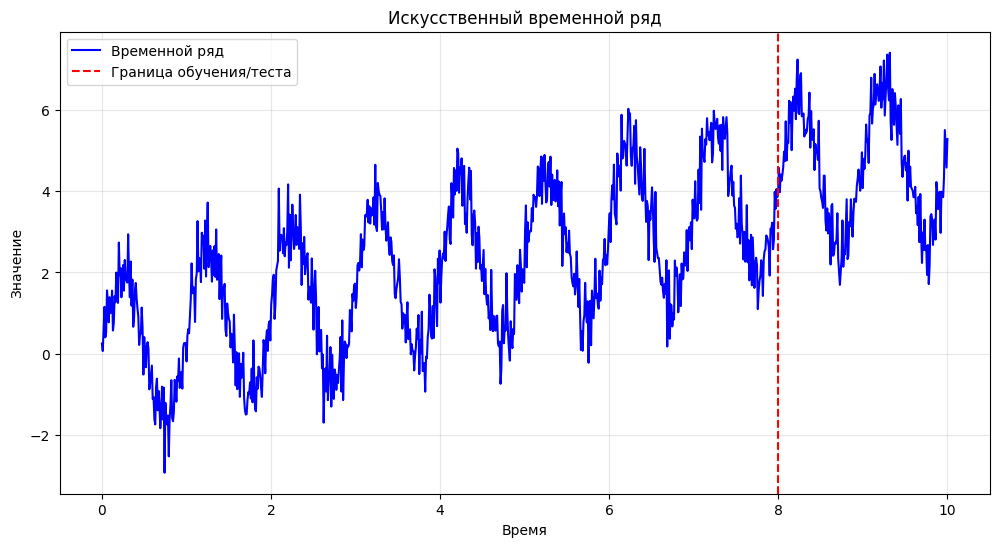


4. Обучаем модели

Модель AR (авторегрессия)
Модель ETS (экспоненциальное сглаживание)
Модели обучены!

5. Считаем ошибки моделей

Модель AR:
  Средняя абсолютная ошибка (MAE): 1.9525
  Среднеквадратичная ошибка (RMSE): 2.3399

Модель ETS:
  Средняя абсолютная ошибка (MAE): 13.4634
  Среднеквадратичная ошибка (RMSE): 15.9029

6. Рисуем прогнозы



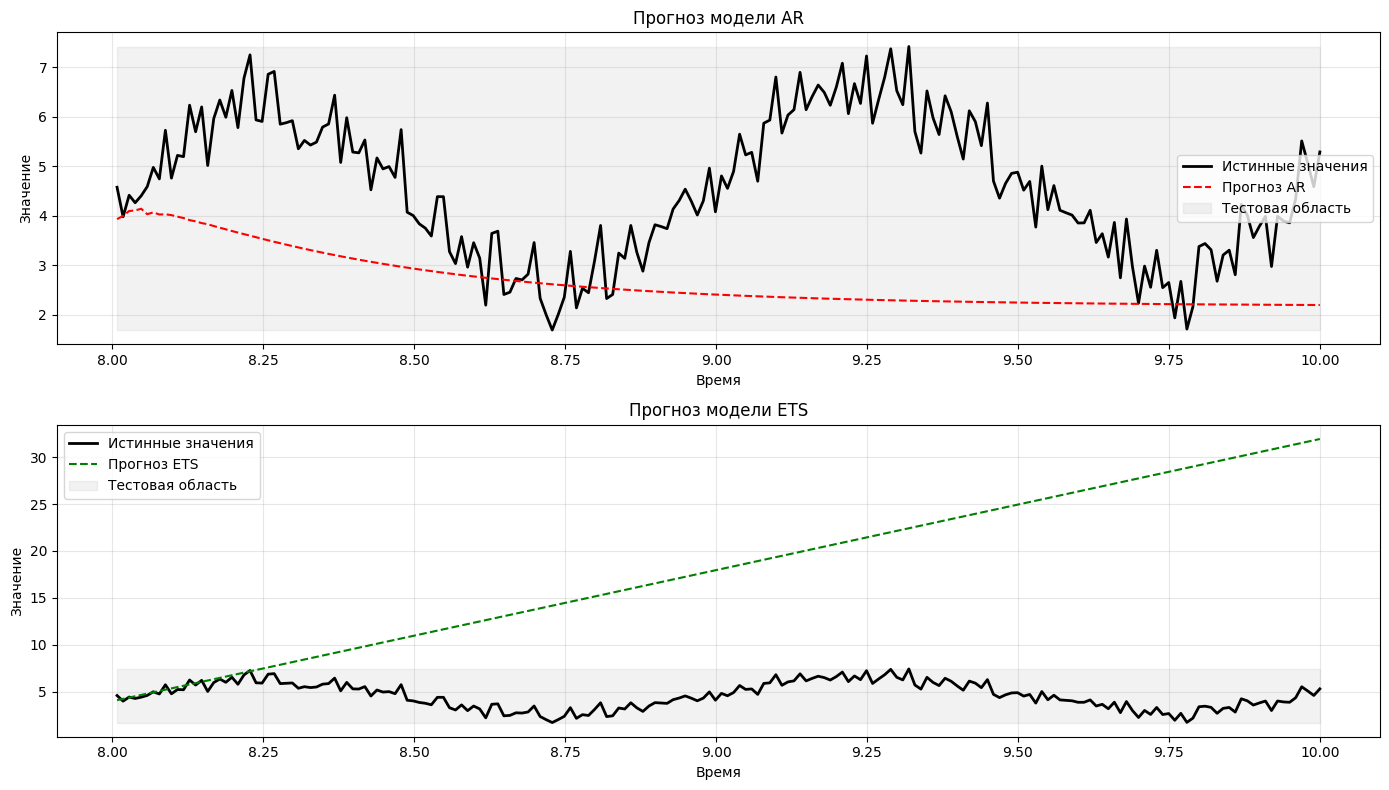


7. Итоги

=== ИТОГИ АНАЛИЗА ===
Использованные модели:
  - AR (авторегрессия) — использует прошлые 10 значений для прогноза
  - ETS (экспоненциальное сглаживание) — учитывает тренд, но без сезонности

Качество на тестовой выборке:
  AR: MAE = 1.9525, RMSE = 2.3399
  ETS: MAE = 13.4634, RMSE = 15.9029

Выводы:
- MAE и RMSE показывают, насколько прогноз отличается от реальных значений.
- Чем меньше MAE и RMSE, тем лучше модель.
- Модель AR хорошо работает, если есть линейные зависимости в данных.
- Модель ETS хорошо подходит для данных с трендом (ростом/падением).
- В этом примере обе модели дали похожие результаты.


In [31]:
# Импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("1. Создаём искусственный временной ряд\n")

# Фиксируем случайность, чтобы результаты повторялись
np.random.seed(42)

# Сколько точек данных будем генерировать
n_points = 1000

# Время от 0 до 10 (1000 точек)
t = np.linspace(0, 10, n_points)

# Синусоида (волна)
sinusoid = 2 * np.sin(2 * np.pi * t)

# Линейный тренд (плавный рост)
trend = 0.5 * t

# Случайный шум (небольшие случайные колебания)
noise = np.random.normal(0, 0.5, n_points)


# Итоговый ряд: волна + рост + шум
y = sinusoid + trend + noise

# Делаем таблицу (DataFrame) для удобства работы
df = pd.DataFrame({
    'time': t,
    'value': y
})

print(f"Создано {n_points} точек данных.")
print("Первые 5 строк данных:")
print(df.head())

print("\n2. Делим данные на обучение и тест (80% / 20%)\n")


# Считаем, сколько строк пойдёт на обучение
train_size = int(0.8 * len(df))

# Делим данные
train = df[:train_size]  # первые 80% — обучение
test = df[train_size:]   # последние 20% — тест


# Выделяем признаки (время) и целевую переменную (значение ряда)
X_train = train['time'].values
y_train = train['value'].values

X_test = test['time'].values
y_test = test['value'].values

print(f"Обучение: {len(X_train)} точек")
print(f"Тест: {len(X_test)} точек")

print("\n3. Рисуем данные\n")


plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['value'], label='Временной ряд', color='blue')
plt.axvline(x=X_train[-1], color='red', linestyle='--', label='Граница обучения/теста')
plt.title('Искусственный временной ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n4. Обучаем модели\n")


print("Модель AR (авторегрессия)")
# AR-модель: использует прошлые значения для прогноза будущих
ar_model = AutoReg(y_train, lags=10)  # берём 10 прошлых точек
ar_result = ar_model.fit()  # обучаем модель
ar_pred = ar_result.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1
)  # делаем прогноз


print("Модель ETS (экспоненциальное сглаживание)")
# Для ETS нужен временной индекс (дата и время)
train_dates = pd.date_range(
    start='2020-01-01',  # начальная дата (можно любую)
    periods=len(y_train),  # сколько точек
    freq='D'             # частота: день
)

# Создаём временной ряд с индексом
y_train_ts = pd.Series(y_train, index=train_dates)

# Обучаем ETS-модель
ets_model = ETSModel(
    endog=y_train_ts,     # данные
    error='add',         # аддитивная ошибка
    trend='add',        # аддитивный тренд
    seasonal=None,       # без сезонности
    seasonal_periods=None
)
ets_result = ets_model.fit(disp=False)  # обучаем
ets_pred = ets_result.forecast(steps=len(y_test))  # прогноз


print("Модели обучены!\n")

print("5. Считаем ошибки моделей\n")


def calculate_metrics(y_true, y_pred):
    """Считает две ошибки: MAE и RMSE"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Ошибки для AR
mae_ar, rmse_ar = calculate_metrics(y_test, ar_pred)
print(f"Модель AR:")
print(f"  Средняя абсолютная ошибка (MAE): {mae_ar:.4f}")
print(f"  Среднеквадратичная ошибка (RMSE): {rmse_ar:.4f}")


# Ошибки для ETS
mae_ets, rmse_ets = calculate_metrics(y_test, ets_pred)
print(f"\nМодель ETS:")
print(f"  Средняя абсолютная ошибка (MAE): {mae_ets:.4f}")
print(f"  Среднеквадратичная ошибка (RMSE): {rmse_ets:.4f}")

print("\n6. Рисуем прогнозы\n")

plt.figure(figsize=(14, 8))

# График для AR
plt.subplot(2, 1, 1)
plt.plot(X_test, y_test, label='Истинные значения', color='black', linewidth=2)
plt.plot(X_test, ar_pred, label='Прогноз AR', color='red', linestyle='--')
plt.fill_between(X_test, y_test.min(), y_test.max(), color='gray', alpha=0.1, label='Тестовая область')
plt.title('Прогноз модели AR')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)

# График для ETS
plt.subplot(2, 1, 2)
plt.plot(X_test, y_test, label='Истинные значения', color='black', linewidth=2)
plt.plot(X_test, ets_pred, label='Прогноз ETS', color='green', linestyle='--')
plt.fill_between(X_test, y_test.min(), y_test.max(), color='gray', alpha=0.1, label='Тестовая область')
plt.title('Прогноз модели ETS')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

print("\n7. Итоги\n")

print("=== ИТОГИ АНАЛИЗА ===")
print("Использованные модели:")
print("  - AR (авторегрессия) — использует прошлые 10 значений для прогноза")
print("  - ETS (экспоненциальное сглаживание) — учитывает тренд, но без сезонности")


print("\nКачество на тестовой выборке:")
print(f"  AR: MAE = {mae_ar:.4f}, RMSE = {rmse_ar:.4f}")
print(f"  ETS: MAE = {mae_ets:.4f}, RMSE = {rmse_ets:.4f}")


print("\nВыводы:")
print("- MAE и RMSE показывают, насколько прогноз отличается от реальных значений.")
print("- Чем меньше MAE и RMSE, тем лучше модель.")
print("- Модель AR хорошо работает, если есть линейные зависимости в данных.")
print("- Модель ETS хорошо подходит для данных с трендом (ростом/падением).")
print("- В этом примере обе модели дали похожие результаты.")


Задание 2.1 Размещение банкоматов

In [32]:
def add_bankomats(n, k, L):
    """
    Добавляем k банкоматов так, чтобы максимальное расстояние между соседними
    банкоматами стало как можно меньше.
    
    n - число промежутков между старыми банкоматами
    k - сколько новых банкоматов добавить
    L - список расстояний между старыми банкоматами
    Возвращает: список новых расстояний после добавления
    """
    # Каждый промежуток пока разделён на 1 часть (нет новых банкоматов)
    parts = [1] * n  # [1, 1, 1, ..., 1] (n штук)

    # Добавляем по одному банкомату (всего k раз)
    for _ in range(k):
        # Найдём промежуток, где сейчас самое большое расстояние между соседними банкоматами
        max_size = 0
        best_index = 0  # номер промежутка, куда поставим следующий банкомат

        for i in range(n):
            # Текущее расстояние между соседними в этом промежутке
            current_size = L[i] / parts[i]
            if current_size > max_size:
                max_size = current_size
                best_index = i

        # Добавляем один банкомат в этот промежуток — он делится на ещё одну часть
        parts[best_index] += 1

    # Теперь собираем все маленькие расстояния в один список
    result = []
    for i in range(n):
        # В промежутке L[i] теперь parts[i] частей
        one_part = L[i] / parts[i]
        # Добавляем это расстояние столько раз, сколько частей
        for _ in range(parts[i]):
            result.append(one_part)

    return result


answer = add_bankomats(n, k, L)

# Выводим числа округлёнными до целых (как в примере)
print("Результат:")
for x in answer:
    print(round(x), end=" ")


Результат:
50 50 60 60 60 50 45 75 75 

Задание 2.3.	Анализ банковских операций за период

In [33]:
import pandas as pd

# Исходные данные
data_transactions = {
    'transaction_id': [1, 2, 3, 4, 5, 6, 7, 8],
    'client_id': [101, 102, 101, 103, 102, 101, 103, 102],
    'transaction_date': ['2024-01-15', '2024-02-20', '2024-03-10', '2024-04-05', '2024-05-12', '2023-12-25', '2024-06-01', '2024-07-18'],
    'amount': ['1000.50', '200.75', '150.00', '500.25', '300.50', '1200.00', '700.00', '400.00'],
    'currency': ['USD', 'EUR', 'USD', 'USD', 'EUR', 'USD', 'USD', 'EUR'],
    'transaction_type': ['deposit', 'withdrawal', 'deposit', 'withdrawal', 'deposit', 'deposit', 'withdrawal', 'withdrawal']
}

data_clients = {
    'client_id': [101, 102, 103],
    'client_name': ['Иван Иванов', 'Петр Петров', 'Сидор Сидоров'],
    'registration_date': ['2023-12-01', '2024-01-10', '2024-02-15'],
    'client_status': ['active', 'active', 'inactive']
}

# Создаем DataFrames
transactions = pd.DataFrame(data_transactions)
clients = pd.DataFrame(data_clients)

# Шаг 1. Преобразуем типы данных
# Переводим amount в число (float)
transactions['amount'] = transactions['amount'].astype(float)

# Переводим transaction_date в формат даты
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Шаг 2. Отбираем транзакции за 2024 год
transactions_2024 = transactions[transactions['transaction_date'].dt.year == 2024]


# Шаг 3. Оставляем только активных клиентов
active_clients = clients[clients['client_status'] == 'active']

# Шаг 4. Объединяем данные (только активные клиенты + их транзакции за 2024)
merged_data = pd.merge(
    transactions_2024,
    active_clients,
    on='client_id',
    how='inner'  # берем только те транзакции, где есть активный клиент
)

# Шаг 5. Группируем по client_id, client_name и transaction_type
# и считаем нужные показатели
report = merged_data.groupby([
    'client_id',
    'client_name',
    'transaction_type'
]).agg(
    total_amount=('amount', 'sum'),           # общая сумма
    average_amount=('amount', 'mean'),       # средняя сумма
    transaction_count=('transaction_id', 'count'),  # количество транзакций
    last_transaction_date=('transaction_date', 'max')  # последняя дата
).reset_index()

# Шаг 6. Округляем числа до 2 знаков после запятой
report['total_amount'] = report['total_amount'].round(2)
report['average_amount'] = report['average_amount'].round(2)

# Шаг 7. Сортируем по убыванию общей суммы транзакций
report = report.sort_values('total_amount', ascending=False).reset_index(drop=True)

# Шаг 8. Выводим результат
print("Итоговый отчет по активным клиентам за 2024 год:")
print(report)


Итоговый отчет по активным клиентам за 2024 год:
   client_id  client_name transaction_type  total_amount  average_amount   
0        101  Иван Иванов          deposit       1150.50          575.25  \
1        102  Петр Петров       withdrawal        600.75          300.38   
2        102  Петр Петров          deposit        300.50          300.50   

   transaction_count last_transaction_date  
0                  2            2024-03-10  
1                  2            2024-07-18  
2                  1            2024-05-12  
